# 3-3. 自动注释（一）

## 1. 背景

我们在3-2的教程中，详细介绍了如何根据marker对细胞进行手动注释的方法。但是随着时代的发展，越来越多的组织，器官被人们注释完。很多初学者对marker的不熟悉，使得其手动注释的准确率较低。这时候，我们就在想，是否可以基于现有的注释数据，构建一个全面的注释图谱，使得我们只需要输入单细胞数据，就能自动输出注释结果。

在这里，我将自动注释算法分为需要GPU的深度学习模型以及不需要GPU的统计学模型两种，我们在（一）中先介绍不需要GPU的统计学模型自动注释。我们在此介绍的算法是SCSA，SCSA可以根据簇特异性marker，查询数据库中每一种细胞类型的marker，选出吻合度最高的一类细胞，如果差异性不够大，那么则选出两类细胞，这时可以被认为是Unknown细胞。



In [1]:
import omicverse as ov
print(f'omicverse version: {ov.__version__}')
import scanpy as sc
print(f'scanpy version: {sc.__version__}')
ov.ov_plot_set()

omicverse version: 1.5.0
scanpy version: 1.7.2


## 2. 加载数据

在这里，我们使用手动注释好的所用到的人类骨髓数据进行注释，使用注释好的数据可以方便我们比较手动注释与自动注释的准确率。

In [15]:
adata = ov.read('s4d8_manual_annotation.h5ad')
adata

AnnData object with n_obs × n_vars = 14814 × 2000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'scDblFinder_score', 'scDblFinder_class', 'leiden_res1', 'major_celltype', 'manual_celltype', 'minor_celltype'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'percent_cells', 'robust', 'mean', 'var', 'residual_variances', 'highly_variable_rank', 'highly_variable_features'
    uns: 'hvg', 'layers_counts', 'leiden', 'leiden_res1_colors', 'log1p', 'major_celltype_colors', 'manual_celltype_colors', 'minor_celltype_colors', 'neighbors', 'scaled|original|cum_su

## 3. 聚类

与手动注释类似，我们使用SCSA模型也需要对单细胞测序数据先进行聚类，在这里，我们的`resolution=2`可以设置地更大一些。

In [16]:
sc.pp.neighbors(adata, n_neighbors=15,
                n_pcs=30,use_rep='scaled|original|X_pca')
sc.tl.leiden(adata, key_added="leiden_res1", resolution=2.0)

computing neighbors
    finished (0:00:00)
running Leiden clustering
    finished (0:00:01)


我们观察不同类别在UMAP图上的分布情况

In [17]:
adata.obsm["X_mde"] = ov.utils.mde(adata.obsm["scaled|original|X_pca"])

<AxesSubplot: title={'center': 'Clusters'}, xlabel='X_mde1', ylabel='X_mde2'>

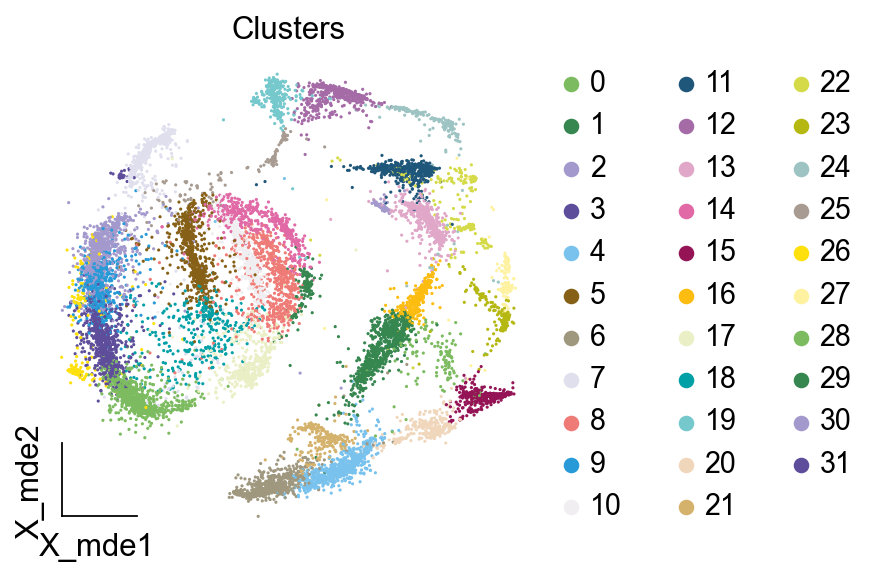

In [5]:
ov.utils.embedding(adata,
                basis='X_mde',
                color=[ "leiden_res1"],
                title=['Clusters'],
                palette=ov.palette()[:],
                show=False,frameon='small',)

## 4. SCSA自动注释

### 4.1 Cellmarker注释

很多paper里，将SCSA作为一个benchmark，认为其注释准确率较低，但实际这跟SCSA所依赖的数据库有关，作者一直将CellMarker数据库停留在1.0版本，直到今年omicverse将SCSA整合，并更新数据库后，这个19年发表的算法也更新了CellMarker数据库。而在omicverse中，我还添加了panglaodb作为第二个参考数据库供读者选择。

我们在这里详细介绍函数`ov.single.pySCSA`的参数:

- foldchange: 这是我们每个簇相对于别的簇的差异倍数，一般设置1.5即可，设置地越高用到的marker越少
- pvalue: 与foldchange对应，我们在计算差异倍数的时候会进行统计学差异显著性分析，通常由于细胞数的原因，pvalue会出现膨胀，所以p值都非常小，我们设置一个常见阈值0.01即可
- celltype: 这个参数包括了`normal`和`cancer`两个参数，当我们设置成cancer的时候，我们可以注释出来自cancersea数据库的12种肿瘤细胞亚型
- target: 我们要使用的目的数据库，目前pySCSA中存放了`cellmarker`, `cancersea`, `panglaodb`三个数据库
- tissue: 我们可以使用`scsa.get_model_tissue()`列出所有支持的组织，默认是使用全部tissue
- model_path: 这里可以设定我们使用的数据库，默认为''，将自动从figshare下载omicverse专用数据库，当然你也可以手动下载


> 注意事项:
> 
> `celltype='cancer'`,`target='cancersea'`需要同时设定

> 数据库:
> 
> pySCSA_2023_v2_plus.db
> - `figshare`:https://figshare.com/ndownloader/files/41369037
> - `百度网盘`: https://pan.baidu.com/s/1IcEpRUhkGw45-J57JnE8IA?pwd=gr9y


In [18]:
scsa=ov.single.pySCSA(adata=adata,
                      foldchange=1.5,
                      pvalue=0.01,
                      celltype='normal',
                      target='cellmarker',
                      tissue='All',
                      model_path='temp/pySCSA_2023_v2_plus.db'                    
)

正式开始注释的环节，我们这里有三个参数

- clustertype: 注释依据的簇名，存放在adata.obs
- cluster: 需要注释的cluster，可以设置为list: ['1','2']表示只注释簇1和簇2
- rank_rep: 是否需要重新计算差异表达基因，由于当细胞数量上去后，差异表达基因的计算会较慢，如果我们已经运算了`sc.tl.rank_genes_groups`，我们可以设置成False停止重复计算

In [ ]:
adata.uns['log1p']['base']=10
res=scsa.cell_anno(clustertype='leiden_res1',
               cluster='all',rank_rep=True)
res.head()

我们可以使用`cell_anno_print`来打印自动注释的结果

In [20]:
scsa.cell_anno_print()

Cluster:0	Cell_type:Natural killer cell|T cell	Z-score:13.273|9.396
Nice:Cluster:1	Cell_type:B cell	Z-score:17.404
Cluster:2	Cell_type:Natural killer cell|T cell	Z-score:11.593|6.514
Cluster:3	Cell_type:Natural killer cell|T cell	Z-score:12.76|8.216
Nice:Cluster:4	Cell_type:B cell	Z-score:12.598
Cluster:5	Cell_type:Natural killer cell|T cell	Z-score:9.54|8.235
Nice:Cluster:6	Cell_type:B cell	Z-score:17.663
Nice:Cluster:7	Cell_type:Natural killer cell	Z-score:14.884
Cluster:8	Cell_type:T cell|CD4+ T cell	Z-score:11.135|5.887
Nice:Cluster:9	Cell_type:Natural killer cell	Z-score:11.839
Cluster:10	Cell_type:T cell|Natural killer cell	Z-score:8.536|5.758
Nice:Cluster:11	Cell_type:Monocyte	Z-score:14.702
Nice:Cluster:12	Cell_type:Natural killer T (NKT) cell	Z-score:16.376
Cluster:13	Cell_type:Monocyte|Natural killer T (NKT) cell	Z-score:14.982|12.323
Cluster:14	Cell_type:T cell|Naive CD4+ T cell	Z-score:4.286|3.828
Nice:Cluster:15	Cell_type:B cell	Z-score:15.455
Cluster:16	Cell_type:Natural 

我们使用`cell_auto_anno`将分数最高的细胞类型注释上，但这个函数不会区分非Nice的细胞注释结果，还存在一些误差。

In [22]:
scsa.cell_auto_anno(adata,clustertype='leiden_res1',
                    key='scsa_celltype_cellmarker')

...cell type added to scsa_celltype_cellmarker on obs of anndata


我们发现自动注释中多注释出了`Hematopoietic stem cell`，这类细胞可能是注释偏差，其对应的簇为24，我们发现其z-score没有高于第二类两倍，10.647｜10.385。此外，我们自动注释没有注释出neuron，neuron对应的是胶质细胞，这是自动注释的局限性

[<AxesSubplot: title={'center': 'Cell type'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'scsa_celltype_cellmarker'}, xlabel='X_mde1', ylabel='X_mde2'>]

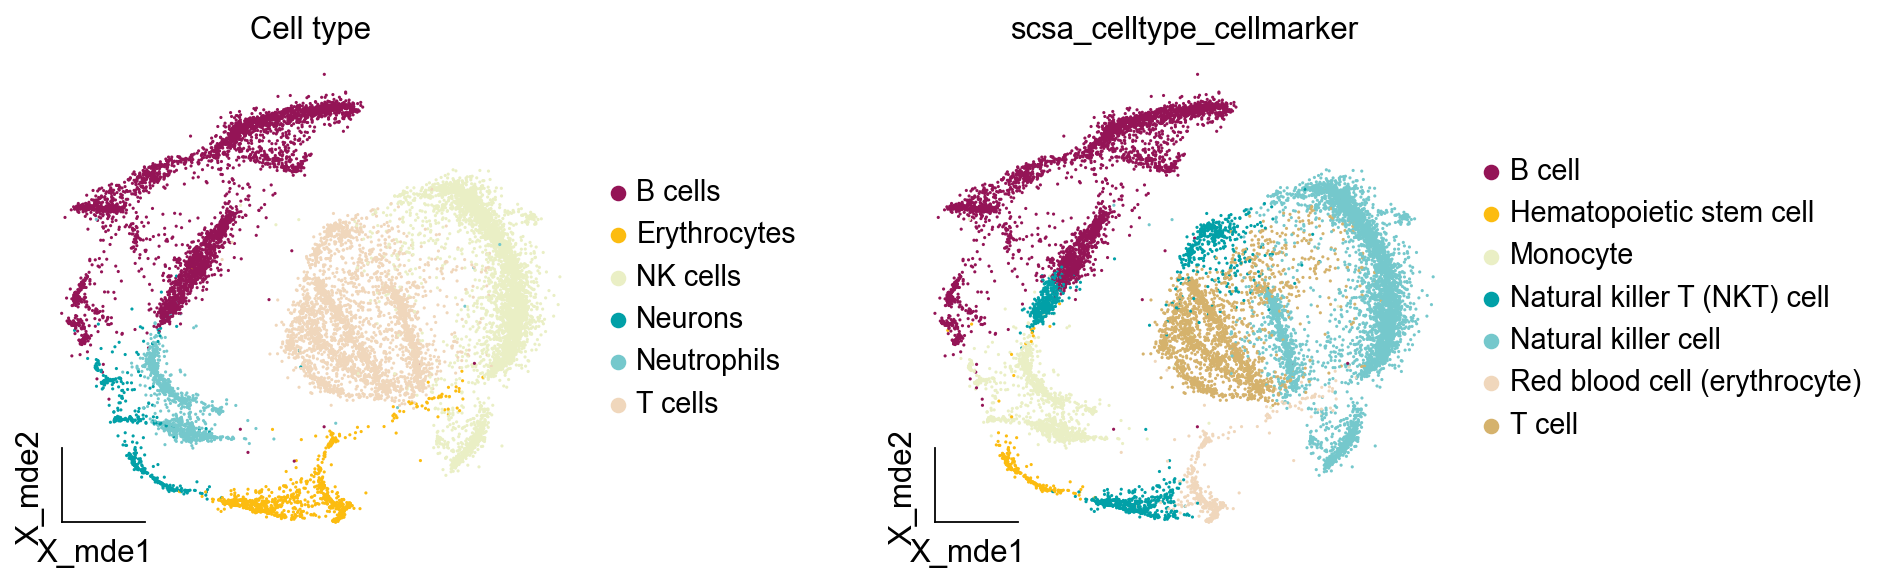

In [28]:
ov.utils.embedding(adata,
                basis='X_mde',
                color=[ "major_celltype","scsa_celltype_cellmarker",],
                title=['Cell type'],
                palette=ov.palette()[15:],
                show=False,frameon='small',wspace=0.45)

### 4.2 panglaodb注释

我们还可以尝试`panglaodb`数据库来注释

In [29]:
scsa=ov.single.pySCSA(adata=adata,
                          foldchange=1.5,
                          pvalue=0.01,
                          celltype='normal',
                          target='panglaodb',
                          tissue='All',
                          model_path='temp/pySCSA_2023_v2_plus.db'
                          
)

In [ ]:
res=scsa.cell_anno(clustertype='leiden_res1',
               cluster='all',rank_rep=True)
res.head()

In [31]:
scsa.cell_auto_anno(adata,clustertype='leiden_res1',
                    key='scsa_celltype_panglaodb')

...cell type added to scsa_celltype_panglaodb on obs of anndata


[<AxesSubplot: title={'center': 'scsa_celltype_panglaodb'}, xlabel='X_mde1', ylabel='X_mde2'>,
 <AxesSubplot: title={'center': 'scsa_celltype_cellmarker'}, xlabel='X_mde1', ylabel='X_mde2'>]

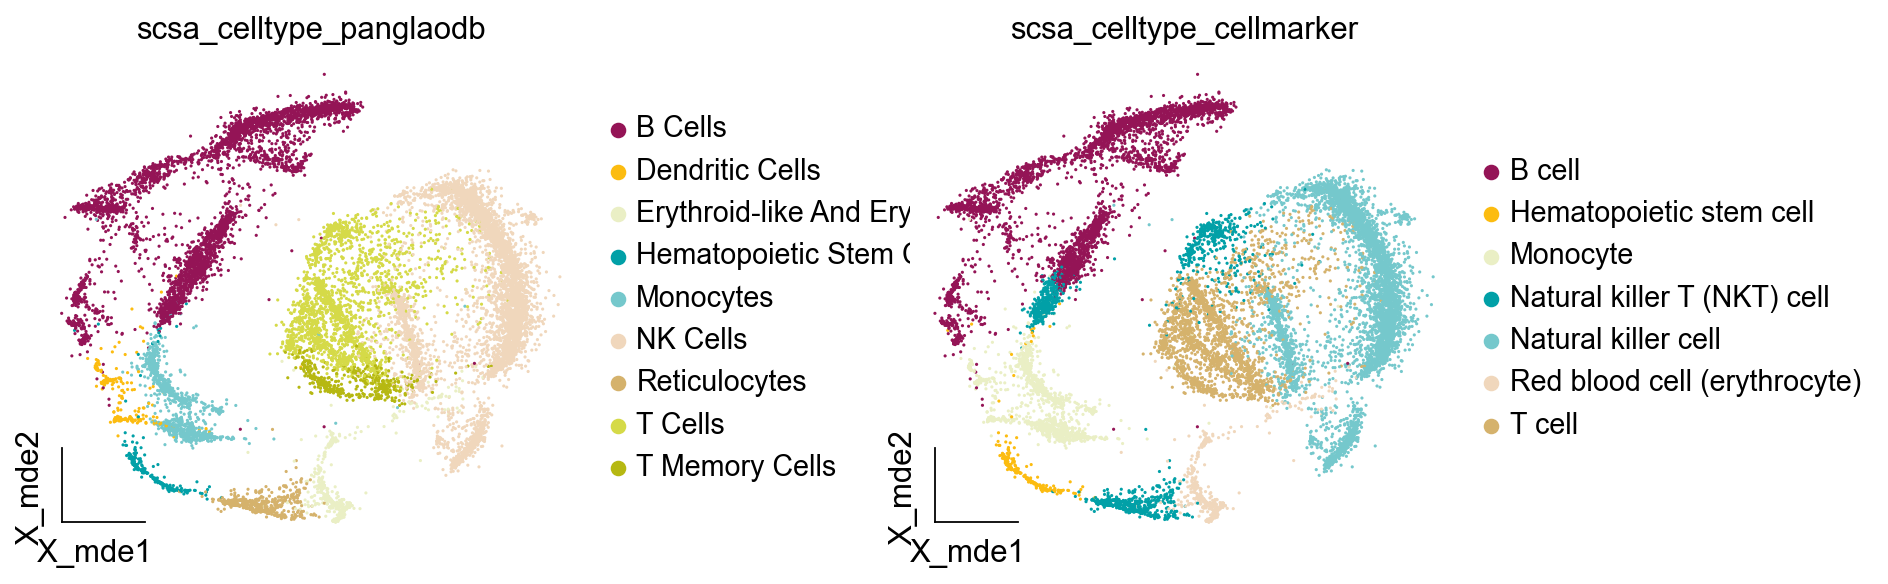

In [38]:
ov.utils.embedding(adata,
                basis='X_mde',
                color=[ "scsa_celltype_panglaodb","scsa_celltype_cellmarker",],
                #title=['Cell type'],
                palette=ov.palette()[15:],
                show=False,frameon='small',wspace=0.45)

有趣的是，panglaodb注释出了Reticulocytes，Erythroid-like两种红细胞，T cells，T memory cells两种T细胞亚群。虽然看起来更准确了，但实际上我们在大类注释时不需要将细胞类型精细化。我们还提供了一个函数`get_celltype_marker`获取指定细胞类型的marker基因

In [33]:
marker_dict=ov.single.get_celltype_marker(adata,clustertype='scsa_celltype_cellmarker')
marker_dict.keys()

...get cell type marker
ranking genes
    finished (0:00:15)


dict_keys(['B cell', 'Hematopoietic stem cell', 'Monocyte', 'Natural killer T (NKT) cell', 'Natural killer cell', 'Red blood cell (erythrocyte)', 'T cell'])

In [36]:
marker_dict['B cell']

array(['AFF3', 'BACH2', 'CD74', 'EBF1', 'BANK1', 'RALGPS2', 'IGHM', 'LYN',
       'FCHSD2', 'ZCCHC7', 'PAX5', 'MEF2C', 'UBE2E2'], dtype=object)

我们可以查询所有支持的tissue，目前支持两种物种：Human与Mouse。我们在后续的更新中会陆续加入斑马鱼，植物等数据库

In [37]:
scsa.get_model_tissue(species='Human')

Version V2.1 [2023/06/27]
DB load: GO_items:47347,Human_GO:3,Mouse_GO:3,
CellMarkers:82887,CancerSEA:1574,PanglaoDB:24223
Ensembl_HGNC:61541,Ensembl_Mouse:55414
########################################################################################################################
------------------------------------------------------------------------------------------------------------------------
Species:Human      Num:298       
------------------------------------------------------------------------------------------------------------------------
  1: Abdomen                              2: Abdominal adipose tissue             3: Abdominal fat pad                  
  4: Acinus                               5: Adipose tissue                       6: Adrenal gland                      
  7: Adventitia                           8: Airway                               9: Airway epithelium                  
 10: Allocortex                          11: Alveolus                          